## 1. Load data and create network

In [83]:
import networkx as nx
import pandas as pd

In [84]:
df_movies = pd.read_csv('datasets/movies.csv')
df_ratings = pd.read_csv('datasets/ratings.csv')

display(df_movies.head())
display(df_ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Add year as new column

In [85]:
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)$')
df_movies['title'] = df_movies['title'].str.replace(r'\((\d{4})\)$', '', regex=True).str.strip()
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


### Transform 'genres' -> one-hot encoding

In [86]:
genres = df_movies['genres'].str.split('|').explode()
unique_genres = genres.unique()

one_hot_encodings = []
for index, row in df_movies.iterrows():
    movie_genres = row['genres'].split('|')
    encoding = [1 if genre in movie_genres else 0 for genre in unique_genres]
    one_hot_encodings.append(encoding)
    
one_hot_df = pd.DataFrame(one_hot_encodings, columns=unique_genres)
df_movies = pd.concat([df_movies, one_hot_df], axis=1)
df_movies.drop(columns=['genres'], inplace=True)
df_movies.dropna(inplace=True)
df_movies.head()

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,1995,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create bipartite (2-modal) network

In [87]:
# movies_uniq = df_movies['title'].unique()
users_uniq = df_ratings['userId'].unique()

In [88]:
G = nx.Graph()

for _, row in df_movies.iterrows():
    G.add_node(f'm{row['movieId']}', movieId=row['movieId'], bipartite=0, year=row['year'], title=row['title'])
    
for user in users_uniq:
    G.add_node(f'u{user}', userId=user, bipartite=1)
    
for _, row in df_ratings.iterrows():
    movie_id = int(row['movieId'])
    user_id = int(row['userId'])
    G.add_edge(f'u{user_id}', f'm{movie_id}', rating=row['rating'])

In [89]:
def print_first_x_nodes(graph, num):
    x = num
    count = 0
    
    for u, data in graph.nodes(data=True):
        if count >= x:
            break
        print(f"Node: {u}, Year: {data['year']}")
        count += 1

        
def print_first_x_edges(graph, num):
    x = num
    count = 0
    
    for u, v, data in graph.edges(data=True):
        if count >= x:
            break
        print(f"Edge: ({u}, {v}), Rating: {data['rating']}")
        count += 1
        
        
print_first_x_nodes(G, 5) 
print_first_x_edges(G, 5)

Node: m1, Year: 1995
Node: m2, Year: 1995
Node: m3, Year: 1995
Node: m4, Year: 1995
Node: m5, Year: 1995
Edge: (m1, u1), Rating: 4.0
Edge: (m1, u5), Rating: 4.0
Edge: (m1, u7), Rating: 4.5
Edge: (m1, u15), Rating: 2.5
Edge: (m1, u17), Rating: 4.5


## 2. Centrality measures

### Degree Centrality for each movie

In [90]:
movie_nodes = []
for node, data in G.nodes(data=True):
    if 'movieId' in data:
        movie_nodes.append(node)
        
movie_projection = nx.bipartite.projection.projected_graph(G, movie_nodes)
degree_centrality = nx.degree_centrality(movie_projection)

In [91]:
for node_id, centrality in degree_centrality.items():
    print(f"Node ID: {node_id}, Degree Centrality: {centrality}")
    
# for node, data in movie_projection.nodes(data=True):
#     print(node, data)

Node ID: m1, Degree Centrality: 0.8898470382917565
Node ID: m2, Degree Centrality: 0.7828765013858947
Node ID: m3, Degree Centrality: 0.5958320500975259
Node ID: m4, Degree Centrality: 0.11508058720870547
Node ID: m5, Degree Centrality: 0.5766348424186428
Node ID: m6, Degree Centrality: 0.7329842931937173
Node ID: m7, Degree Centrality: 0.585874140232009
Node ID: m8, Degree Centrality: 0.34462580843855867
Node ID: m9, Degree Centrality: 0.2908325633918489
Node ID: m10, Degree Centrality: 0.7050610820244329
Node ID: m11, Degree Centrality: 0.6532183554049892
Node ID: m12, Degree Centrality: 0.4925572323170106
Node ID: m13, Degree Centrality: 0.2094240837696335
Node ID: m14, Degree Centrality: 0.2944256236526024
Node ID: m15, Degree Centrality: 0.46011703110563595
Node ID: m16, Degree Centrality: 0.7933477055743764
Node ID: m17, Degree Centrality: 0.6281695924443076
Node ID: m18, Degree Centrality: 0.5693460630325429
Node ID: m19, Degree Centrality: 0.6904835232522328
Node ID: m20, Degre

### Top 5 movies with highest centrality degree

In [92]:
degree_sorted = sorted(
    degree_centrality.items(),
    key=lambda i: i[1],
    reverse=True
)

top_five = []
for node_id, _ in degree_sorted[:5]:
    top_five.append(node_id)
    
movies = []
for node, data in movie_projection.nodes(data=True):
    if node in top_five:
        movies.append((data['movieId'], data['title']))
        
print("== Top five movies ==")
for movieId, title in movies:
    print(movieId, title)

== Top five movies ==
260 Star Wars: Episode IV - A New Hope
296 Pulp Fiction
356 Forrest Gump
593 Silence of the Lambs, The
2571 Matrix, The


### Top 5 movies with highest centrality degree (rated 1 and 2)

In [93]:
low_rated_movies = []
for user, movie, data in G.edges(data=True):
    rating = data['rating']
    if rating in [1, 2]:
        low_rated_movies.append((user, movie))

low_rated_subgraph = G.edge_subgraph(low_rated_movies)

low_degree_centrality = nx.degree_centrality(low_rated_subgraph)

In [94]:
low_movie_degrees = dict(filter(
    lambda i: i[0][0] == 'm',
    low_degree_centrality.items()
))

low_degree_sorted = sorted(
    low_movie_degrees.items(),
    key=lambda i: i[1],
    reverse=True
)

low_top_five = []
for node_id, _ in low_degree_sorted[:5]:
    low_top_five.append(node_id)
    
low_movies = []
for node, data in low_rated_subgraph.nodes(data=True):
    if node in low_top_five:
        low_movies.append((data['movieId'], data['title']))
        
print("== Top five low rated movies ==")
for movieId, title in low_movies:
    print(movieId, title)

== Top five low rated movies ==
788 Nutty Professor, The
153 Batman Forever
19 Ace Ventura: When Nature Calls
344 Ace Ventura: Pet Detective
2628 Star Wars: Episode I - The Phantom Menace


## 3. Projection to a single-modal network

### Nodes - movies, edges - between 2 movies rated by the same users, edge weight - number of people who rated both movies

In [31]:
movie_projection = nx.bipartite.weighted_projected_graph(G, movie_nodes)

In [38]:
for u, v, data in movie_projection.edges(data=True):
    common_users = len(set(G[u])) + len(set(G[v]))
    movie_projection[u][v]['weight'] = common_users

## Betweenness centrality

In [47]:
print(f'Number of nodes: {len(movie_projection.nodes())}')
print(f'Number of edges: {len(movie_projection.edges())}')

# filter edges to compute betweenness centrality in reasonable time
filtered_edges = [(u, v, data) for u, v, data in movie_projection.edges(data=True) if data['weight'] > 200]
print(f'After filetring\nNumber of edges: {len(filtered_edges)}')

filtered_graph = nx.Graph(filtered_edges)

Number of nodes: 9742
Number of edges: 13157672
After filetring
Number of edges: 208257


In [53]:
betweenness = nx.betweenness_centrality(filtered_graph, weight='weight')

In [54]:
between_sorted = sorted(
    betweenness.items(),
    key=lambda i: i[1],
    reverse=True
)

between_top_five = []
for node_id, _ in between_sorted[:5]:
    between_top_five.append(node_id)
    
between_movies = []
for node, data in movie_projection.nodes(data=True):
    if node in between_top_five:
        between_movies.append((data['movieId'], data['title']))
        
print("== Top five betweenness movies ==")
for movieId, title in between_movies:
    print(movieId, title)

== Top five betweenness movies ==
1 Toy Story
780 Independence Day (a.k.a. ID4)
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
1210 Star Wars: Episode VI - Return of the Jedi
4993 Lord of the Rings: The Fellowship of the Ring, The


## 4. Communities detection

In [268]:
# Create projection of old movies to compute communities in reasonable time
old_movies = []
for node, data in G.nodes(data=True):
    if 'year' in data and data['year'] and int(data['year']) < 1980:
        old_movies.append(node)

old_movies_projection = nx.bipartite.weighted_projected_graph(G, old_movies)

print(f'Number of nodes: {len(old_movies_projection.nodes())}')
nodes_with_empty_attributes = [node for node, data in old_movies_projection.nodes(data=True) if not data]
old_movies_projection.remove_nodes_from(nodes_with_empty_attributes)
print(f'Number of nodes with attributes: {len(old_movies_projection.nodes())}')

# remove weak edges to compute communities in reasonable time
print(f'Number of edges: {len(old_movies_projection.edges())}')
edges_to_remove = [(u, v) for u, v, data in old_movies_projection.edges(data=True) if data['weight'] < 3]
old_movies_projection.remove_edges_from(edges_to_remove)
print(f'Number of edges with threshold higher than 3: {len(old_movies_projection.edges())}')

# remove isolated nodes
print(f'Number of nodes: {len(old_movies_projection.nodes())}')
isolated_nodes = [node for node, degree in old_movies_projection.degree() if degree == 0]
old_movies_projection.remove_nodes_from(isolated_nodes)
print(f'Number of nodes that are not isolated: {len(old_movies_projection.nodes())}')

Number of nodes: 9680
Number of nodes with attributes: 1559
Number of edges: 372014
Number of edges with threshold higher than 3: 47841
Number of nodes: 1559
Number of nodes that are not isolated: 655


In [269]:
print(len(old_movies))
print(len(old_movies_projection.nodes()))
print(len(old_movies_projection.edges()))

1559
655
47841


### Detect communites

In [270]:
communities = nx.algorithms.community.greedy_modularity_communities(old_movies_projection, weight='weight')

### Visualise communites

In [277]:
import matplotlib.pyplot as plt

colors = range(len(communities))

node_color_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_color_map[node] = colors[i]

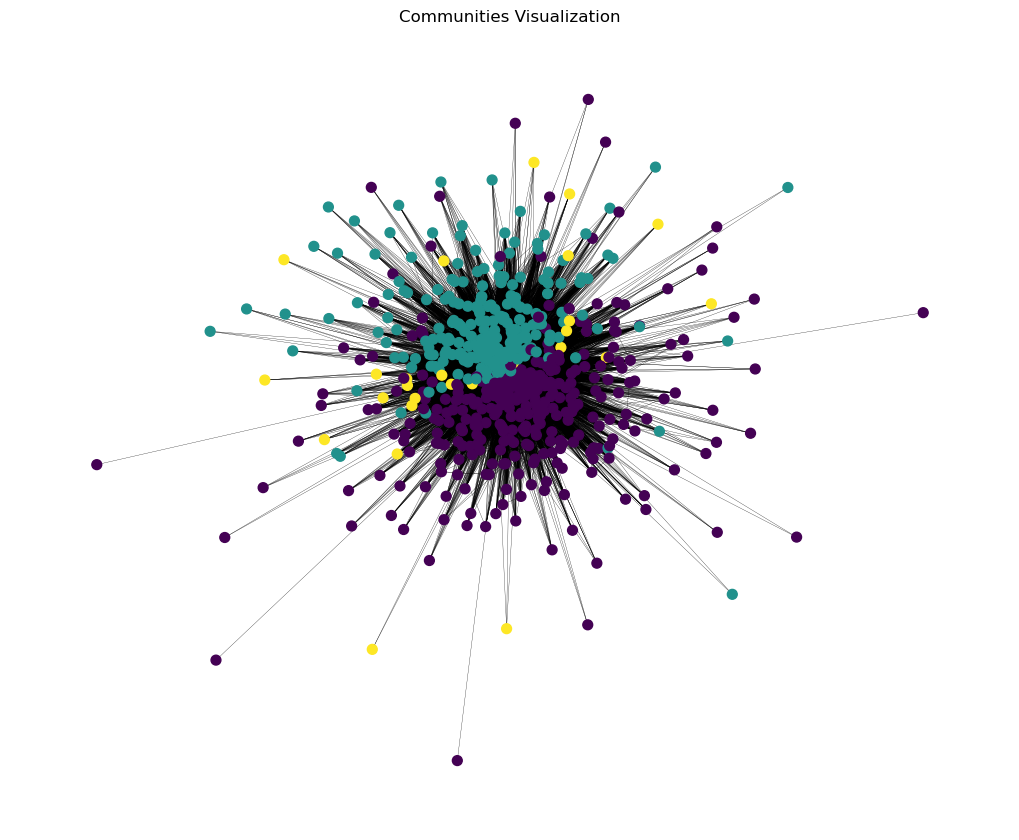

In [285]:
plt.figure(figsize=(10, 8))
pos = nx.layout.spring_layout(old_movies_projection)
nx.draw(
    old_movies_projection, 
    pos, 
    node_color=[node_color_map[node] for node in old_movies_projection.nodes()], 
    with_labels=False, 
    node_size=50,
    width=0.2
)
plt.title('Communities Visualization')
plt.show()